## Basic RNN2RNN Model

- test data : [Kaggle m5-forecasting-accuracy competition first **1000** item sale series](https://www.kaggle.com/c/m5-forecasting-accuracy/overview)
- metric and loss function: RMSE

In [1]:
import os
import gc
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from  datetime import datetime, timedelta
import scipy as sp
%matplotlib inline

import torch
from torch.optim import Adam
from torch.nn import MSELoss

from deepseries.models import BasicSeq2Seq
from deepseries.train import Learner
from deepseries.dataset import TimeSeries, Property, Seq2SeqDataLoader
from deepseries.nn.loss import RMSELoss
from deepseries.optim import ReduceCosineAnnealingLR

In [57]:
DIR = "../data"
N_ROWS = 1000
BATCH_SIZE = 32


LAGS = [365]
MAX_LAGS = max(LAGS)
DROP_BEFORE = 1300

SEQ_LAST = False
ENC_LEN = 512
DEC_LEN = 28

VALID_LEN = 28
TEST_LEN = 28

TRAIN_LAST_DAY = 1913
USE_SERIES_LEN = TRAIN_LAST_DAY - DROP_BEFORE + 1 + 28

CAL_DTYPES={"event_name_1": "category", "event_name_2": "category", "event_type_1": "category", 
         "event_type_2": "category", "weekday": "category", 'wm_yr_wk': 'int16', "wday": "int16",
        "month": "int16", "year": "int16", "snap_CA": "int16", 'snap_TX': 'int16', 'snap_WI': 'int16' }
PRICE_DTYPES = {"store_id": "category", "item_id": "category", "wm_yr_wk": "int16","sell_price":"float32" }

# FIRST_DAY = datetime(2011, 1, 29) 
# FORECAST_DAY = datetime(2016,4, 25) 

In [58]:
def load_data():
    label_encoders = {}
    
    prices = pd.read_csv(os.path.join(DIR, "sell_prices.csv"), dtype = PRICE_DTYPES)
    for col, col_dtype in PRICE_DTYPES.items():
        if col_dtype == "category":
            if col not in label_encoders:
                label_encoders[col] = LabelEncoder().fit(prices[col].astype(str).fillna("None"))
            prices[col] = label_encoders[col].transform(prices[col].astype(str).fillna("None")).astype("int16")
    
    cal = pd.read_csv(os.path.join(DIR, "calendar.csv"), dtype = CAL_DTYPES)
    cal["date"] = pd.to_datetime(cal["date"])
    for col, col_dtype in CAL_DTYPES.items():
        if col_dtype == "category":
            if col not in label_encoders:
                label_encoders[col] = LabelEncoder().fit(cal[col].astype(str).fillna("None"))
            cal[col] = label_encoders[col].transform(cal[col].astype(str).fillna("None")).astype("int16")
    
    numcols = [f"d_{day}" for day in range(DROP_BEFORE, TRAIN_LAST_DAY+1)]
    catcols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
    dtype = {numcol:"float32" for numcol in numcols} 
    dtype.update({col: "category" for col in catcols if col != "id"})
    dt = pd.read_csv(os.path.join(DIR, "sales_train_validation.csv"), 
                     usecols = catcols + numcols, dtype = dtype, nrows=N_ROWS)
    
    for col in catcols:
        if col != "id":
            if col not in label_encoders:
                label_encoders[col] = LabelEncoder().fit(dt[col].astype(str).fillna("None"))
            dt[col] = label_encoders[col].transform(dt[col].astype(str).fillna("None")).astype("int16")

    for day in range(TRAIN_LAST_DAY+1, TRAIN_LAST_DAY+28+1):
        dt[f"d_{day}"] = np.nan
    
    product = dt[catcols].copy()
    print(f"product shape {product.shape}")

    dt = pd.melt(dt,
                  id_vars = catcols,
                  value_vars = [col for col in dt.columns if col.startswith("d_")],
                  var_name = "d",
                  value_name = "sales")

    dt = dt.merge(cal[['d', 'wm_yr_wk']], on= "d", copy = False)
    dt = dt.merge(prices, on = ["store_id", "item_id", "wm_yr_wk"], copy = False)
    dt['d'] = dt['d'].str.replace('d_', '').astype("int32")
    price = dt.pivot(index="id", columns="d", values="sell_price")
    xy = dt.pivot(index="id", columns="d", values="sales")
    del dt; gc.collect()
    print(f"sale_xy shape {xy.shape}")
    print(f"price shape {price.shape}")

    cal_use_col = ['date', 'wday', 'month', 'year', 'event_name_1',
    'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX',
    'snap_WI']
    cal = cal[cal_use_col]
    cal['year'] = cal['year'] - cal['year'].min()
    cal['quarter'] = cal.date.dt.quarter
    cal = cal.drop("date", axis=1).T
    cal = cal[xy.columns]
    print(f"calendar shape {cal.shape}")
    
    submission = pd.read_csv(os.path.join(DIR, "sample_submission.csv"))
    print(f"submisson shape {submission.shape}")
    return xy, price, cal, product, submission

df_series, df_price, df_calendar, df_product, df_sub = load_data()

product shape (1000, 6)
sale_xy shape (1000, 642)
price shape (1000, 642)
calendar shape (11, 642)
submisson shape (60980, 29)


In [59]:
# series
series = np.log1p(df_series.values)
price = np.log1p(df_price.values)

C:\Users\evilp\AppData\Local\Continuum\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log1p
  
C:\Users\evilp\AppData\Local\Continuum\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log1p
  This is separate from the ipykernel package so we can avoid doing imports until


In [60]:
# series state
series_nan = np.isnan(series).astype("int8")
series_zero = (series == 0).astype("int8")

In [61]:
# series statistics

series_valid_masked = np.ma.masked_array(series, mask=series_nan.astype(bool))

series_mean = series_valid_masked.mean(axis=1).data
series_std = series_valid_masked.std(axis=1).data
series_skew = sp.stats.mstats.skew(series_valid_masked, axis=1).data
series_kurt = np.clip(sp.stats.mstats.kurtosis(series_valid_masked, axis=1).data, None, 10)

In [62]:
# series normalization

series = np.nan_to_num(
    (series - np.expand_dims(series_mean, 1)) / (np.expand_dims(series_std, 1) + 1e-7), 0.).astype("float32")

In [63]:
# series statistic features

series_mean_mean = series_mean.mean()
series_mean_std = series_mean.std()
series_std_mean = series_std.mean()
series_std_std = series_std.std()
series_skew_mean = series_skew.mean()
series_skew_std = series_skew.std()
series_kurt_mean = series_kurt.mean()
series_kurt_std = series_kurt.std()

xy_series_mean = (series_mean - series_mean_mean) / series_mean_std
xy_series_std = (series_std - series_std_mean) / series_std_std
xy_series_skew = (series_skew - series_skew_mean) / series_skew_std
xy_series_kurt = (series_kurt - series_kurt_mean) / series_kurt_std


xy_series_stats = np.stack([xy_series_mean, xy_series_std, xy_series_skew, xy_series_kurt], axis=1)
x_series_label = np.stack([series_nan, series_zero], axis=1)
series = np.expand_dims(series, axis=1)

In [64]:
# series categorical features

xy_series_cat = df_product.set_index("id").values.astype("int64")

In [65]:
# calendar feature

def periodic_feature(x, T):
    psin = np.sin(x * np.pi * 2 / T)
    pcos = np.cos(x * np.pi * 2 / T)
    return np.stack([psin, pcos], axis=0)

xy_calendar_embed = np.concatenate([
    periodic_feature(df_calendar.T['wday'].values, 7),
    periodic_feature(df_calendar.T['month'].values, 12),
    periodic_feature(df_calendar.T['quarter'].values, 4),
    df_calendar.T[['snap_CA', 'snap_TX', 'snap_WI']].values.T
])
xy_calendar_embed = np.expand_dims(xy_calendar_embed, 0)

xy_event_type = np.expand_dims(
    df_calendar.T[['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']].T.values, 0)

In [66]:
class ForwardSpliter:
    
    def split(self, time_idx, enc_len, dec_len, valid_size):
        if valid_size < 1:
            valid_size = int(np.floor(len(time_idx) * valid_size))
        valid_idx = time_idx[-(valid_size+enc_len):]
        train_idx = time_idx[:-valid_size]
        return train_idx, valid_idx
    
spliter = ForwardSpliter()

train_idx, valid_idx = spliter.split(np.arange(series.shape[2]), ENC_LEN, DEC_LEN, VALID_LEN+TEST_LEN)
valid_idx, test_idx = spliter.split(valid_idx, ENC_LEN, DEC_LEN, TEST_LEN)

In [67]:
train_series = TimeSeries(series[:, :, train_idx].transpose(0, 2, 1))
valid_series = TimeSeries(series[:, :, valid_idx].transpose(0, 2, 1))
test_series = TimeSeries(series[:, :, test_idx].transpose(0, 2, 1))

train_xy_series_stats = Property(xy_series_stats)
valid_xy_series_stats = Property(xy_series_stats)
test_xy_series_stats = Property(xy_series_stats)

train_x_series_label = TimeSeries(x_series_label[: ,: ,train_idx].transpose(0, 2, 1))
valid_x_series_label = TimeSeries(x_series_label[:, :, valid_idx].transpose(0, 2, 1))
test_x_series_label = TimeSeries(x_series_label[:, :, test_idx].transpose(0, 2, 1))

train_xy_cat = Property(xy_series_cat)
valid_xy_cat = Property(xy_series_cat)
test_xy_cat = Property(xy_series_cat)

train_xy_event = TimeSeries(xy_event_type[:, :, train_idx].transpose(0, 2, 1), idx_map=dict(zip(np.arange(N_ROWS), [0] * N_ROWS)))
valid_xy_event = TimeSeries(xy_event_type[:, :, valid_idx].transpose(0, 2, 1), idx_map=dict(zip(np.arange(N_ROWS), [0] * N_ROWS)))
test_xy_event = TimeSeries(xy_event_type[:, :, test_idx].transpose(0, 2, 1), idx_map=dict(zip(np.arange(N_ROWS), [0] * N_ROWS)))

train_xy_calendar_embed = TimeSeries(xy_calendar_embed[:, :, train_idx].transpose(0, 2, 1), idx_map=dict(zip(np.arange(N_ROWS), [0] * N_ROWS)))
valid_xy_calendar_embed = TimeSeries(xy_calendar_embed[:, :, valid_idx].transpose(0, 2, 1), idx_map=dict(zip(np.arange(N_ROWS), [0] * N_ROWS)))
test_xy_calendar_embed = TimeSeries(xy_calendar_embed[:, :, test_idx].transpose(0, 2, 1), idx_map=dict(zip(np.arange(N_ROWS), [0] * N_ROWS)))

In [72]:
series_nan[:, :-28].mean()

0.007501628664495114

In [73]:
train_dl = Seq2SeqDataLoader(train_series, 
                             batch_size=BATCH_SIZE, 
                             enc_lens=ENC_LEN, 
                             dec_lens=DEC_LEN, 
                             use_cuda=True, 
                             mode='train', 
                             time_free_space=10,
                             enc_num_feats=[train_xy_series_stats, train_x_series_label, train_xy_calendar_embed], 
                             enc_cat_feats=[train_xy_cat, train_xy_event], 
                             dec_num_feats=[train_xy_series_stats, train_xy_calendar_embed], 
                             dec_cat_feats=[train_xy_cat, train_xy_event],
                             seq_last=False,
                            )

valid_dl = Seq2SeqDataLoader(valid_series, 
                             batch_size=BATCH_SIZE, 
                             enc_lens=ENC_LEN, 
                             dec_lens=DEC_LEN, 
                             use_cuda=True, 
                             mode='valid', 
                             time_free_space=0,
                             enc_num_feats=[valid_xy_series_stats, valid_x_series_label, valid_xy_calendar_embed], 
                             enc_cat_feats=[valid_xy_cat, valid_xy_event], 
                             dec_num_feats=[valid_xy_series_stats, valid_xy_calendar_embed],
                             dec_cat_feats=[valid_xy_cat, valid_xy_event], 
                             seq_last=False
                              )

test_dl = Seq2SeqDataLoader(test_series, 
                             batch_size=BATCH_SIZE, 
                             enc_lens=ENC_LEN, 
                             dec_lens=DEC_LEN, 
                             use_cuda=True, 
                             mode='test', 
                             time_free_space=0,
                             enc_num_feats=[test_xy_series_stats, test_x_series_label, test_xy_calendar_embed], 
                             enc_cat_feats=[test_xy_cat, test_xy_event], 
                             dec_num_feats=[test_xy_series_stats, test_xy_calendar_embed],
                             dec_cat_feats=[test_xy_cat, test_xy_event], 
                            seq_last=False,
                      )

In [74]:
model = BasicSeq2Seq(series_dim=1, hidden_dim=128, enc_num=15, 
                enc_cat=[(3049, 16), (7, 1), (10, 1), (3, 1), (3, 1), (32, 4), (5, 1), (5, 1), (3, 1)],
                dec_num=13,
                dec_cat=[(3049, 16), (7, 1), (10, 1), (3, 1), (3, 1), (32, 4), (5, 1), (5, 1), (3, 1)],
                dropout=0.2, n_layers=2, rnn_type="lstm"
               )
opt = Adam(model.parameters(), 0.002)
loss_fn = RMSELoss()
lr_scheduler = ReduceCosineAnnealingLR(opt, 64, eta_min=1e-4, gamma=0.998)
model.cuda()
learner = Learner(model, opt, loss_fn, './m5_rnn', verbose=-1, lr_scheduler=lr_scheduler)
learner.fit(10, train_dl, valid_dl, patient=64, start_save=100, early_stopping=False)

[[04/23/2020 15:47:53]] start training >>>>>>>>>>>  see log: tensorboard --logdir ./m5_rnn\logs
[[04/23/2020 15:48:06]] epoch 1 / 10, batch 100%, train loss 0.9766, valid loss 1.0092, cost 0.2 min
[[04/23/2020 15:48:20]] epoch 2 / 10, batch 100%, train loss 0.9715, valid loss 1.0036, cost 0.2 min
[[04/23/2020 15:48:33]] epoch 3 / 10, batch 100%, train loss 0.9656, valid loss 0.9975, cost 0.2 min
[[04/23/2020 15:48:47]] epoch 4 / 10, batch 100%, train loss 0.9757, valid loss 0.9962, cost 0.2 min
[[04/23/2020 15:49:00]] epoch 5 / 10, batch 100%, train loss 0.9616, valid loss 0.9920, cost 0.2 min
[[04/23/2020 15:49:14]] epoch 6 / 10, batch 100%, train loss 0.9591, valid loss 0.9878, cost 0.2 min
[[04/23/2020 15:49:28]] epoch 7 / 10, batch 100%, train loss 0.9499, valid loss 0.9950, cost 0.2 min
[[04/23/2020 15:49:42]] epoch 8 / 10, batch 100%, train loss 0.9535, valid loss 0.9893, cost 0.2 min
[[04/23/2020 15:49:56]] epoch 9 / 10, batch 100%, train loss 0.9644, valid loss 0.9880, cost 0.2

In [80]:
learner.fit(100, train_dl, valid_dl, patient=64, start_save=100, early_stopping=False)

[[04/23/2020 15:51:02]] start training >>>>>>>>>>>  see log: tensorboard --logdir ./m5_rnn\logs
[[04/23/2020 15:51:17]] epoch 11 / 110, batch 100%, train loss 0.9468, valid loss 0.9959, cost 0.2 min
[[04/23/2020 15:51:31]] epoch 12 / 110, batch 100%, train loss 0.9409, valid loss 0.9867, cost 0.2 min
[[04/23/2020 15:51:45]] epoch 13 / 110, batch 100%, train loss 0.9452, valid loss 0.9916, cost 0.2 min
[[04/23/2020 15:51:59]] epoch 14 / 110, batch 100%, train loss 0.9414, valid loss 0.9965, cost 0.2 min
[[04/23/2020 15:52:13]] epoch 15 / 110, batch 100%, train loss 0.9370, valid loss 0.9918, cost 0.2 min
[[04/23/2020 15:52:26]] epoch 16 / 110, batch 100%, train loss 0.9399, valid loss 0.9917, cost 0.2 min
[[04/23/2020 15:52:40]] epoch 17 / 110, batch 100%, train loss 0.9382, valid loss 0.9949, cost 0.2 min
[[04/23/2020 15:52:54]] epoch 18 / 110, batch 100%, train loss 0.9315, valid loss 0.9968, cost 0.2 min
[[04/23/2020 15:53:08]] epoch 19 / 110, batch 100%, train loss 0.9233, valid los

[[04/23/2020 16:09:07]] epoch 89 / 110, batch 100%, train loss 0.8350, valid loss 1.0516, cost 0.2 min
[[04/23/2020 16:09:20]] epoch 90 / 110, batch 100%, train loss 0.8147, valid loss 1.0592, cost 0.2 min
[[04/23/2020 16:09:34]] epoch 91 / 110, batch 100%, train loss 0.8275, valid loss 1.0545, cost 0.2 min
[[04/23/2020 16:09:48]] epoch 92 / 110, batch 100%, train loss 0.8348, valid loss 1.0562, cost 0.2 min
[[04/23/2020 16:10:01]] epoch 93 / 110, batch 100%, train loss 0.8187, valid loss 1.0501, cost 0.2 min
[[04/23/2020 16:10:15]] epoch 94 / 110, batch 100%, train loss 0.7990, valid loss 1.0667, cost 0.2 min
[[04/23/2020 16:10:28]] epoch 95 / 110, batch 100%, train loss 0.7936, valid loss 1.0629, cost 0.2 min
[[04/23/2020 16:10:42]] epoch 96 / 110, batch 100%, train loss 0.8074, valid loss 1.0622, cost 0.2 min
[[04/23/2020 16:10:56]] epoch 97 / 110, batch 100%, train loss 0.7961, valid loss 1.0639, cost 0.2 min
[[04/23/2020 16:11:10]] epoch 98 / 110, batch 100%, train loss 0.8252, va

In [81]:
def predict_submission(model, test_dl):
    model.eval()
    test_dl.test()
    preds = []
    for batch in test_dl:
        preds.append(model.predict(**batch).cpu().detach().numpy())
    preds = np.concatenate(preds, axis=0).squeeze()
    preds = np.expm1(preds * np.expand_dims(series_std, 1) + np.expand_dims(series_mean, 1))
    return preds

preds = predict_submission(learner.model, test_dl)
top1 = pd.read_csv("../data/submission_top1.csv").set_index("id").loc[df_series.index]

In [82]:
def plot(idx):
    plt.figure(figsize=(16, 5))
#     plt.plot(df_series.iloc[idx, -56:-28].values)
    plt.plot(preds[idx], label='wave')
    plt.plot(top1.iloc[idx, 1:].values, label='lgb')
#     plt.title(f"enc {df_xy.iloc[idx, -56:-28].values.mean():.2f} pred {preds[idx].mean():.2f} top1 mean {top1.iloc[idx, 1:].values.mean():.2f}")
    plt.legend()

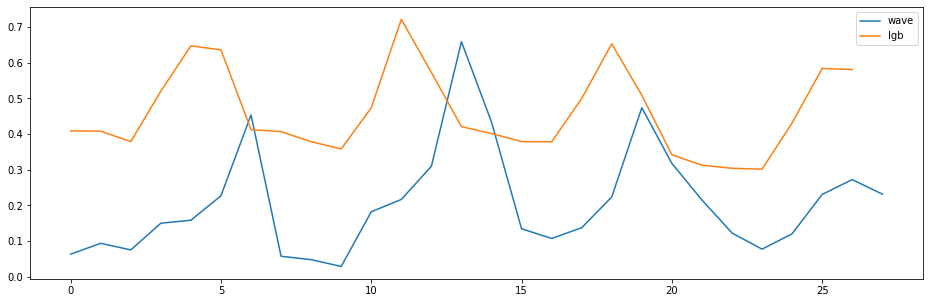

In [86]:
plot(2)

In [89]:
preds = predict_submission(learner.model, valid_dl)

In [104]:
pd.DataFrame(preds).mean(1)

0      0.541747
1      0.070160
2      0.215761
3      1.381991
4      0.640397
         ...   
995    1.288999
996    4.578080
997    0.642700
998    1.773958
999    0.054329
Length: 1000, dtype: float64

In [105]:
pd.DataFrame(valid_dl.xy.values.squeeze()[:, -28:]).mean(1)

0      0.289408
1     -0.408422
2      0.327670
3     -0.124861
4      0.210488
         ...   
995    0.365585
996   -0.237647
997   -0.934368
998    0.147295
999   -0.367463
Length: 1000, dtype: float32

In [88]:
top1.mean().mean()

1.1953029063497234

In [ ]:

# plt.figure(figsize=(16, 8))
# plt.plot(pd.read_csv("./data/submission_top1.csv").mean(1).iloc[:30490], alpha=0.5, label='lgb')
# plt.plot(pd.DataFrame(preds).mean(1), label='wave', alpha=0.5)
# plt.figure(figsize=(16, 2))
# plt.plot(df_xy.dropna(axis=1).iloc[:, -28:].mean(1).values, label='enc', alpha=0.5)
# plt.figure(figsize=(16, 2))
# plt.plot(df_xy.dropna(axis=1).iloc[:, ].mean(1).values, label='all', alpha=0.5)
# plt.figure(figsize=(16, 2))
# plt.plot(xy_mean)
# plt.legend()



# sort_id = pd.Series(dict(zip(np.arange(df_xy.shape[0]), sub_ids.sort_values().index.values))).values

# pd.DataFrame(preds[sort_id]).mean(axis=1)

# pd.DataFrame(preds).mean(axis=1)

# df_xy.mean(axis=1)

# pd.DataFrame({'sub_ids': sub_ids, 'xy_ids': xy_ids})

# pd.read_csv("./data/submission_top1.csv").set_index("id").mean().mean()

# pd.DataFrame(sub_ids).reset_index()

# xy_ids = pd.Series(df_xy.index.values)

# df_sub.iloc[: preds.shape[0], 1:] = preds
# df_sub.iloc[preds.shape[0]:, 1:] = preds

# df_sub.to_csv("./data/sub_0412_1.csv", index=None)

